In [1]:
from nltk.stem import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
import string

f = open('englishST.txt','r')
stopwords = f.readlines()
for i in range (len(stopwords)):
    stopwords[i] = stopwords[i].replace('\n','')
f.close()
s=open('mormon.txt')
data=s.read()
stemmer = PorterStemmer()
lines = data.strip().split('\n')
books = []
chapters = []
content = []
inverted_index = {}
current_chapter = None
current_book = None
verse_number = None
verse_content = None

In [2]:
def add_content(matrix, row, col, value):
    row = int(row)
    col = int(col)
    while len(matrix) <= row:
        matrix.append([])
    while len(matrix[row]) <= col:
        matrix[row].append([])
    matrix[row][col] = value

In [3]:
def add_to_index(word, book, chapter, verse, position):
    if word not in inverted_index:
        inverted_index[word] = []
    inverted_index[word].append({"book": book, "chapter": chapter, "verse": verse, "position" : position})
def processtext(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [
        stemmer.stem(word)
        for word in tokens
        if word not in stopwords and word.isalnum()
    ]
    return filtered_tokens

In [4]:
for line in lines:
    match_book = re.match(r'\s*THE BOOK OF\s(.*)', line)
    match_verse = re.match(r'(\d+):(\d+)\s*(.*)', line)
    match_chapter = re.match(r"^(.*?)\s+Chapter\s+(\d+)$", line)
    
    if match_book:
        current_book = match_book.group(1)
        books.append(current_book)
    elif match_chapter:
        chapter_name = match_chapter.group(1)
        current_chapter = int(match_chapter.group(2))
        chapters.append({
            "name": chapter_name,
            "number": current_chapter 
        })
    elif match_verse:
        if verse_content is not None:
            text = processtext(verse_content)
            add_content(content, current_chapter, verse_number, verse_content)
            for position, word in enumerate(text):
                add_to_index(word, current_book, current_chapter, verse_number, position)
        verse_number = int(match_verse.group(2))
        verse_content = match_verse.group(3)
    else:
        if verse_content is not None:
            verse_content += " " + line.strip()

if verse_content is not None:
    add_content(content, current_chapter, verse_number, verse_content)
    text = processtext(verse_content)
    for position, word in enumerate(text):
        add_to_index(word, current_book, current_chapter, verse_number, position)

In [5]:
#inverted_index

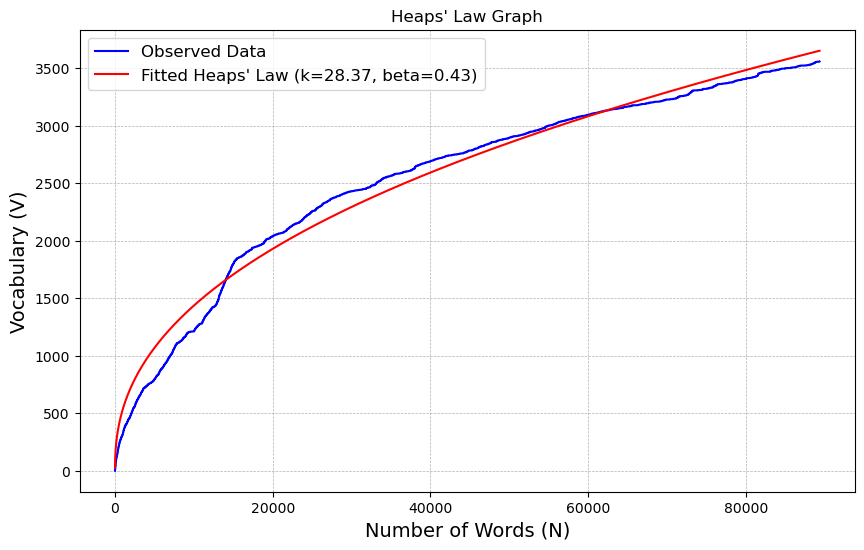

In [6]:
from collections import defaultdict
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

all_tokens = []
for line in lines:
    all_tokens.extend(processtext(line))
unique_words = set()
total_words = []
vocabulary_size = []

for i, word in enumerate(all_tokens):
    unique_words.add(word)
    total_words.append(i + 1)
    vocabulary_size.append(len(unique_words))
def heaps_law(N, k, beta):
    return k * (N ** beta)
popt, _ = curve_fit(heaps_law, total_words, vocabulary_size, maxfev=10000)
k, beta = popt
plt.figure(figsize=(10, 6))
plt.plot(total_words, vocabulary_size, label="Observed Data", color="blue")
plt.plot(
    total_words,
    heaps_law(np.array(total_words), k, beta),
    label=f"Fitted Heaps' Law (k={k:.2f}, beta={beta:.2f})",
    color="red")
plt.title("Heaps' Law Graph")
plt.xlabel("Number of Words (N)", fontsize=14)
plt.ylabel("Vocabulary (V)", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()


In [7]:
def boolean_search(query):
    query = processtext(query)
    terms = []
    operators = []
    for token in query:
        if token in ["and", "or", "not"]:
            operators.append(token)
        else:
            terms.append(token)
    def get_term_locations(term):
        return set(
            (entry['book'], entry['chapter'], entry['verse'])
            for entry in inverted_index.get(term, [])
        )
    
    # ida query tae kelma yrj3 placetha bah ndiroha f other searchs as well kima phrase search
    if len(terms) == 1:
        return get_term_locations(terms[0])
    current_result = get_term_locations(terms[0])
    for i, operator in enumerate(operators):
        next_term = terms[i + 1]
        next_result = get_term_locations(next_term)
        if operator == "and":
            current_result = current_result.intersection(next_result)
        elif operator == "or":
            current_result = current_result.union(next_result)
        elif operator == "not":
            current_result = current_result.difference(next_result)
    return current_result

In [8]:
queries = {
    1: "lehi and father",
    2: "war or kill",
    3: "Babylon not king"
}
results_boolean = []
for num, query in queries.items():
    docs = boolean_search(query)
    for doc in docs:
        results_boolean.append(f'{num}, {doc}')
with open('results.boolean.txt', "w") as file:
    for line in results_boolean:
        file.write(line + "\n")


In [9]:
def phrase_search(inverted_index, phrase):
    words = processtext(phrase)
    print("Processed Words:", words) 
    posting_lists = [inverted_index.get(word, []) for word in words]
    if any(len(postings) == 0 for postings in posting_lists):
        return "Phrase not found in the documents."
    common_docs = set((entry['book'], entry['chapter'], entry['verse']) for entry in posting_lists[0])
    for postings in posting_lists[1:]:
        common_docs.intersection_update(
            (entry['book'], entry['chapter'], entry['verse']) for entry in postings)
    result_docs = []
    for doc in common_docs:
        doc_postings = [
            [entry['position'] for entry in postings if (entry['book'], entry['chapter'], entry['verse']) == doc]
            for postings in posting_lists
        ]
        for start_pos in doc_postings[0]:
            if all((start_pos + i) in doc_postings[i] for i in range(len(words))):
                result_docs.append(doc)
                break
    if result_docs:
        result_str = ', '.join([f"Book: {doc[0]}, Chapter: {doc[1]}, Verse: {doc[2]}" for doc in result_docs])
        return f'They appear in: {result_str}'
    else:
        return "Phrase not found in the documents."

In [32]:
print(phrase_search(inverted_index," And it came to pass that he saw One descending out of the midst of heaven"))

Processed Words: ['pass', 'descend', 'midst', 'heaven']
They appear in: Book: 1 NEPHI, Chapter: 1, Verse: 9


In [11]:
def proximity_search(inverted_index, phrase, proximity=5):
    words = processtext(phrase)
    posting_list = [
        [entry for entry in inverted_index.get(word, []) if entry.get('book') and entry.get('chapter') and entry.get('verse')]
        for word in words
    ]
    if any(len(postings) == 0 for postings in posting_list):
        return "Phrase not found in the documents."
    
    common_docs = set(
        (entry['book'], entry['chapter'], entry['verse']) for entry in posting_list[0]
    )
    for postings in posting_list[1:]:
        common_docs.intersection_update(
            (entry['book'], entry['chapter'], entry['verse']) for entry in postings
        )
    result_docs = []
    
    for doc in common_docs:
        doc_postings = [
            [entry['position'] for entry in postings if (entry['book'], entry['chapter'], entry['verse']) == doc]
            for postings in posting_list
        ]
        for start_pos in doc_postings[0]:
            if all(
                any(abs(start_pos - pos2) <= proximity for pos2 in doc_postings[j])
                for j in range(1, len(doc_postings))
            ):
                result_docs.append(doc)
                break
    if result_docs:
        result_str = ', '.join([f"Book: {doc[0]}, Chapter: {doc[1]}, Verse: {doc[2]}" for doc in result_docs])
        return f'They appear in: {result_str}'
    else:
        return "Phrase not found in the documents."

In [34]:
print(proximity_search(inverted_index,"record language"))

They appear in: Book: MOSIAH, Chapter: 8, Verse: 6, Book: MOSIAH, Chapter: 8, Verse: 12, Book: HELAMAN, Chapter: 5, Verse: 18, Book: 1 NEPHI, Chapter: 3, Verse: 19, Book: OMNI, Chapter: 1, Verse: 17, Book: 1 NEPHI, Chapter: 1, Verse: 2


In [13]:
import math
from collections import defaultdict
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def create_documents_from_index(inverted_index, content):
    documents = defaultdict(list)
    for word, postings in inverted_index.items():
        for posting in postings:
            book = posting["book"]
            chapter = posting["chapter"]
            verse = posting["verse"]
            documents[(book, chapter,verse)].append(word)
    return documents
def compute_tf(doc_text):
    tf = defaultdict(int)
    for term in doc_text:
        tf[term] += 1
    for term in tf:
        tf[term] = 1 + math.log10(tf[term]) if tf[term] > 0 else 0
    return tf
def compute_df(inverted_index):
    df = defaultdict(int)
    for term, postings in inverted_index.items():
        df[term] = len(postings)
    return df
def compute_idf(df, N):
    idf = {}
    for term, doc_freq in df.items():
        idf[term] = math.log10(N / doc_freq) if doc_freq > 0 else 0
    return idf
def compute_tfidf(documents, inverted_index):
    N = len(documents)
    df = compute_df(inverted_index)
    idf = compute_idf(df, N)
    tfidf_scores = {}
    for doc_id, doc_text in documents.items():
        tf = compute_tf(doc_text)
        tfidf_scores[doc_id] = {}
        for term, tf_score in tf.items():
            tfidf_scores[doc_id][term] = tf_score * idf.get(term, 0)
    return tfidf_scores
    
def tfidf_search(query, inverted_index, documents):
    tfidf_scores = compute_tfidf(documents, inverted_index)
    query_terms = processtext(query)
    query_tfidf = compute_tf(query_terms)
    query_df = compute_df(inverted_index)
    query_idf = compute_idf(query_df, len(documents))
    query_scores = {term: query_tfidf.get(term, 0) * query_idf.get(term, 0) for term in query_terms}
    all_terms = set(query_scores.keys()).union(*[set(doc.keys()) for doc in tfidf_scores.values()])
    query_vector = np.array([query_scores.get(term, 0) for term in all_terms])
    doc_vectors = np.array([[doc_tfidf.get(term, 0) for term in all_terms] for doc_tfidf in tfidf_scores.values()])
    similarities = cosine_similarity([query_vector], doc_vectors).flatten()
    ranked_docs = [(doc_id, score) for doc_id, score in zip(tfidf_scores.keys(), similarities) if score > 0]
    ranked_docs.sort(key=lambda x: x[1], reverse=True)
    return ranked_docs

In [14]:
queries = {
    1: "lehi father",
    2: "And we did take courage with our small force which we had received",
    3: "For it came to pass in the commencement of the first year"
}
documents = create_documents_from_index(inverted_index, content)
results = []
for num, query in queries.items():
    ranked_results = tfidf_search(query, inverted_index, documents)
    if ranked_results:
        for doc, score in ranked_results:
            results.append(f"Query {num}: Document {doc}, Score {score}")
with open('ranked.results.txt', "w") as file:
    for line in results:
        file.write(line + "\n")

In [15]:
with open('index.txt', 'w') as f:
    df = compute_df(inverted_index)
    for word, entries in inverted_index.items():
        f.write(f"Word: {word} (DF: {df[word]})\n")
        for entry in entries:
            f.write(f"  Book: {entry['book']}, Chapter: {entry['chapter']}, Verse: {entry['verse']}, Position: {entry['position']}\n")
        f.write("\n")
